# Mesa Schelling example - Schelling Segregation Model

[[Code explanation]](https://towardsdatascience.com/introduction-to-mesa-agent-based-modeling-in-python-bcb0596e1c9a) **Note that the final interactive visualization part we will cover in the later parts of the course**

## Background

The Schelling (1971) segregation model is a classic of agent-based modeling, demonstrating how agents following simple rules lead to the emergence of qualitatively different macro-level outcomes. Agents are randomly placed on a grid. There are two types of agents, one constituting the majority and the other the minority. All agents want a certain number (generally, 3) of their 8 surrounding neighbors to be of the same type in order for them to be happy. Unhappy agents will move to a random available grid space. While individual agents do not have a preference for a segregated outcome (e.g. they would be happy with 3 similar neighbors and 5 different ones), the aggregate outcome is nevertheless heavily segregated.

In [1]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Agent

class SchellingAgent(Agent):
    '''
    Schelling segregation agent
    '''
    
    # 1 Initialization
    def __init__(self, pos, model, agent_type):
        '''
         Create a new Schelling agent.

         Args:
            unique_id: Unique identifier for the agent.
            x, y: Agent initial location.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type

    # 2 Step function
    def step(self):
    
        n_neighbors = len(self.model.grid.get_neighbors(self.pos, True))

        # if there are no neighbors - agent is happy and stays
        if n_neighbors == 0:
            self.model.happy += 1
            return
        
        similar_neighbors = 0
        neighbors = self.model.grid.neighbor_iter(self.pos)
            
        # calculate the number of similar neighbours
        for neighbor in neighbors:
            if neighbor.type == self.type:
                similar_neighbors += 1
                        
        # if the Agent is happy with it's neighbourhood - it stays
        loc_happines = (similar_neighbors/n_neighbors) * 100
        if loc_happines >= self.model.homophily:
            self.model.happy += 1
            return
            
        # if the Agent is unhappy - perform move to better empty cell
        empty_happines_list = {}
        for empty in self.model.grid.empties:
            
            n_empty_neighbors = len(self.model.grid.get_neighbors(empty, True))
            
            # if at new location there are no neighbors - agent moves
            if n_empty_neighbors == 0:
                self.model.grid.move_agent(self, empty)
                return
            
            similar = 0
            empty_neighbors = self.model.grid.neighbor_iter(empty)
            
            for neighbor in empty_neighbors:
                if neighbor.type == self.type:
                    similar += 1
                    
            # build a happines priority list of all possible empty cells
            empty_loc_happines = (similar / n_empty_neighbors) * 100
            #if empty_loc_happines >= self.model.homophily:
            #    self.model.grid.move_agent(self, empty)
            #    return
            
            empty_happines_list[empty] = empty_loc_happines
            
        # move to a higest happines place from such list of empties, if happines is as high as at current location
        max_happines_empty_loc = max(empty_happines_list, key=empty_happines_list.get)
        
        if empty_happines_list[max_happines_empty_loc] >= loc_happines:
            self.model.grid.move_agent(self, max_happines_empty_loc)

In [3]:
# Data collection

def get_morans_i(model):
    '''
    Find Moran's I for all agents and neighbours on the grid.
    '''
    
    x_kappa = model.minority_pc
    N = model.schedule.get_agent_count()
    edges_var = 0
    edges_sum = 0
    total_edges = 0
    
    for agent in model.schedule.agents:
        edges_var += (agent.type - x_kappa) ** 2
        for neighbor in model.grid.neighbor_iter(agent.pos):
            total_edges += 1
            edges_sum += (agent.type - x_kappa) * (neighbor.type - x_kappa)
            
    return (N * edges_sum) / (total_edges * edges_var)

def get_segregation_edges(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_edges = 0
    total_edges = 0
    for agent in model.schedule.agents:
        for neighbor in model.grid.neighbor_iter(agent.pos):
            total_edges += 1
            if neighbor.type == agent.type:
                segregated_edges += 1
    return segregated_edges / total_edges

def get_segregation(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.neighbor_iter(agent.pos):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

In [4]:
# Model

class SchellingModel(Model):
    '''
    Model class for the Schelling segregation model.
    '''

    def __init__(self, height, width, density, minority_pc, homophily):
        '''
        Create a new Schelling model.

         Args:
            width: Horizontal axis of the grid which is used together with Height to define the total number of agents in the system.
            height: Vertical axis of the grid which is used together with Width to define the total number of agents in the system.
            density: Define the population density of agent in the system. Floating value from 0 to 1.
            fraction minority: The ratio between blue and red. Blue is represented as the minority while red is represented as the majority. Floating value from 0 to 1. If the value is higher than 0.5, blue will become the majority instead.
            homophily: Define the number of similar neighbors required for the agents to be happy. Integer value range from 0 to 8 since you can only be surrounded by 8 neighbors.
        '''
        super().__init__()
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.happy = 0
        self.datacollector = DataCollector(
            {"Happy": "happy", "Segregated_Agents": get_segregation, "Segregated_Edges": get_segregation_edges, "Morans_I": get_morans_i},  # Model-level count of happy agents
            # For testing purposes, agent's individual x and y
            {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]})

        self.running = True

        # Set up agents
        # We use a grid iterator that returns
        # the coordinates of a cell as well as
        # its contents. (coord_iter)
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if random.random() < self.density:
                if random.random() < self.minority_pc:
                    agent_type = 1
                else:
                    agent_type = 0

                agent = SchellingAgent((x, y), self, agent_type)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        # Spontaneous move 1%
        spontaneous_agents_count = 0
        shuffled_agents = self.schedule.agent_buffer(shuffled = True)
        for agent in shuffled_agents:
            if spontaneous_agents_count / self.schedule.get_agent_count() <= 0.01:
                agent.spontaneous_move = True
                spontaneous_agents_count += 1
            else:
                break
            
        self.happy = 0  # 1 Reset counter of happy agents
        self.schedule.step()
        
        # 2 collect data
        self.datacollector.collect(self)
        
        # 3 Stop the model if all agents are happy
        if self.happy == self.schedule.get_agent_count():
            self.running = False

Now we instantiate a model instance: a 10x10 grid, with an 80% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 3 similar neighbors.

In [5]:
model = SchellingModel(50, 50, 0.98, 0.5, 60)

We want to run the model until all the agents are happy with where they are. However, there's no guarentee that a given model instantiation will *ever* settle down. So let's run it for either 100 steps or until it stops on its own, whichever comes first:

In [6]:
while model.running and model.schedule.steps < 100:
    model.step()

print('The Schelling Model ran for {} steps'.format(model.schedule.steps))

The Schelling Model ran for 100 steps


# Visualization of data

In [7]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    
    if agent.type == 0:
        portrayal["Color"] = "Red"
    else:
        portrayal["Color"] = "Blue"

    return portrayal

grid = CanvasGrid(agent_portrayal, 20, 20, 500, 500)
server = ModularServer(SchellingModel,
                       [grid],
                       "Schelling Model",
                       {"density":0.98, "width":20, "height":20, "minority_pc":0.5, "homophily":20})
server.port = 8540 # The default
#server.launch()

The model has a DataCollector object, which checks and stores how many agents are happy at the end of each step. It can also generate a pandas DataFrame of the data it has collected:

In [8]:
model_out = model.datacollector.get_model_vars_dataframe()
model_out.head()

,Happy,Segregated_Agents,Segregated_Edges,Morans_I
0,1243,0.336052,0.799106,0.598212
1,2052,0.519168,0.860291,0.720582
2,2194,0.582790,0.884463,0.768927
3,2251,0.620718,0.895799,0.791597
4,2281,0.645595,0.903504,0.807008


Finally, we can plot the 'happy' series:

<AxesSubplot:>

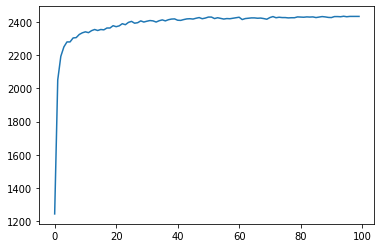

In [9]:
model_out.Happy.plot()

For testing purposes, here is a table giving each agent's x and y values at each step.

In [12]:
x_positions = model.datacollector.get_agent_vars_dataframe()
x_positions.head()

x   y
Step AgentID        
1    (0, 0)   29  40
     (0, 1)   10  12
     (0, 2)   34  20
     (0, 3)   33  34
     (0, 4)   27  26

<AxesSubplot:xlabel='Step'>

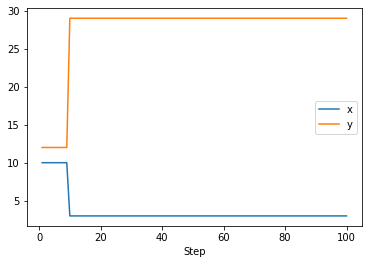

In [17]:
x_positions.xs((0,1), level="AgentID").plot(y=["x", "y"])

# Effect of Homophily on segregation

Now, we can do a parameter sweep to see how segregation changes with homophily.

First, we create a function which takes a model instance and returns what fraction of agents are segregated -- that is, have no neighbors of the opposite type.

In [132]:
from mesa.batchrunner import batch_run

params = {"height": 20, "width": 20, "density": 0.98, "minority_pc": 0.5, 
              "homophily": range(0,100, 13)}

results = batch_run(
    SchellingModel,
    parameters=params,
    iterations=3,
    max_steps=100,
    display_progress=True,
)

24it [00:03,  6.11it/s]


### Complete data is available for each model instantiation for each agent for each step

In [133]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'height', 'width', 'density',
       'minority_pc', 'homophily', 'Happy', 'Segregated_Agents',
       'Segregated_Edges', 'Morans_I', 'AgentID', 'x', 'y'],
      dtype='object')


<AxesSubplot:title={'center':'Segregated_Agents'}, xlabel='homophily'>

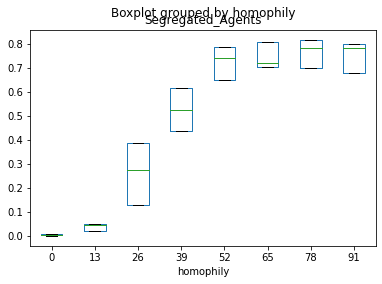

In [134]:
results_df.boxplot(by ='homophily', column =['Segregated_Agents'], grid=False)

<AxesSubplot:title={'center':'Segregated_Agents'}, xlabel='homophily'>

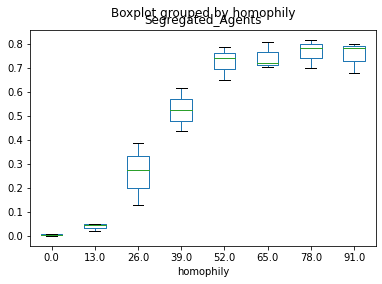

In [135]:
results_df.groupby(by=["RunId"]).median().boxplot(by ='homophily', column =['Segregated_Agents'], grid=False)

<AxesSubplot:title={'center':'Segregated_Edges'}, xlabel='homophily'>

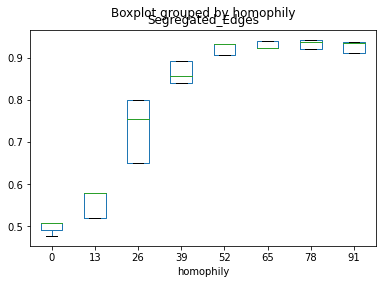

In [136]:
results_df.boxplot(by ='homophily', column =['Segregated_Edges'], grid=False)

<AxesSubplot:title={'center':'Segregated_Edges'}, xlabel='homophily'>

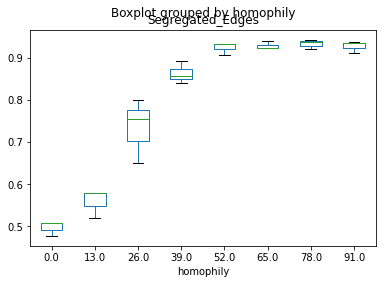

In [137]:
results_df.groupby(by=["RunId"]).median().boxplot(by ='homophily', column =['Segregated_Edges'], grid=False)

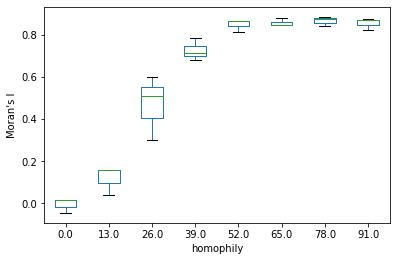

In [138]:
results_df.groupby(by=["RunId"]).median().boxplot(by ='homophily', column =['Morans_I'], grid=False)
plt.suptitle(None)
plt.title(None)
plt.ylabel("Moran's I")
plt.savefig('morans_i_plot.eps')

In [139]:
results_df.groupby(by=["RunId", "iteration", "Step"]).median()

,,,height,width,density,minority_pc,homophily,Happy,Segregated_Agents,Segregated_Edges,Morans_I,x,y
RunId,iteration,Step,,,,,,,,,,,
0,0,0,20.0,20.0,0.98,0.5,0.0,391.0,0.005115,0.507853,0.015707,NaN,NaN
1,1,0,20.0,20.0,0.98,0.5,0.0,392.0,0.000000,0.477214,-0.045573,NaN,NaN
2,0,4,20.0,20.0,0.98,0.5,26.0,389.0,0.275064,0.754617,0.509235,10.0,10.0
3,0,5,20.0,20.0,0.98,0.5,39.0,391.0,0.613811,0.891574,0.783148,9.0,10.0
4,0,1,20.0,20.0,0.98,0.5,13.0,392.0,0.045918,0.579427,0.158854,9.0,9.5
5,1,4,20.0,20.0,0.98,0.5,39.0,387.0,0.436693,0.841121,0.682243,10.0,10.0
6,0,100,20.0,20.0,0.98,0.5,52.0,390.0,0.739130,0.931937,0.863874,10.0,9.0
7,1,100,20.0,20.0,0.98,0.5,13.0,390.0,0.022727,0.519133,0.038265,9.0,9.5
8,1,100,20.0,20.0,0.98,0.5,26.0,378.0,0.127226,0.650485,0.300971,9.0,10.0
